<a href="https://colab.research.google.com/github/atulsnjena/test/blob/br1/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Understanding and getting the data

We will be using the Speech Audio only dataset from RAVDESS.
Speech file (Audio_Speech_Actors_01-24.zip, 215 MB) contains 1440 files: 60 trials per actor x 24 actors = 1440

In [ ]:
!wget -nv "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip"

2021-10-04 17:24:44 URL:https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip [208468073/208468073] -> "Audio_Speech_Actors_01-24.zip" [1]


In [ ]:
!wget -nv "https://www.dropbox.com/s/zdjhaz3pl7gc2tn/TESS.zip"

2021-10-04 17:24:47 URL:https://ucf390df47329d26f19130810c88.dl.dropboxusercontent.com/cd/0/inline2/BXbgffvBhwLpikwkso0t4EkCl5byKcHUnAI1fKYcz4RVx-w7kf3jHhtO46cCG3QWdb6CD8CvHhmnertOKkmBcFof_GjKJfEl-x1XJTg7NtSBLBwoN6kRE_oNLZ5FxIY_qJxrQ2MRpkfgWLBRIGjSgJ-IbzJxC-heMGp39IJmWun1E3BkuTcaxTczVtMnOV--IRBZmusgymnYFD28JPzeLYYO3pquLGA7BTpxrNBcYKgi9wLbJhq-om_Cx-jrMNdjMkathpIKbVYAO7qsOYDbyvXOLbaRjr-81uExOKNVrzazjqw1-wxA_Wo-BOp-yo2G5NhTG47T-mN5qmzvaU_xX39evfiOVPmmlkrDTnw54soo4MdBSsGlz8UEMS94GXLG6CI/file [223829029/223829029] -> "TESS.zip" [1]


In [ ]:
!unzip -q "TESS.zip" -d "TESS"
!rm "TESS.zip"

The Toronto Emotional Speech 
Set (TESS). This is a simulated dataset that was created in 2010 by researchers from the 
University of Toronto Psychology Department. It contains recordings from two actors, 
both females. The younger actor was 26 years old at the time of recording, while the 
older actor was 64 years old. They have recorded 2,800 sentences in seven different 
emotions – anger, disgust, fear, happy, surprise, sad, and neutral. Unlike RAVDESS, this 
is a balanced dataset with each emotion class having 400 data samples.
All audio files were recorded at 16-bits per sample, at a sampling rate of 
24,414 Hz, and saved in WAV audio file format

In [ ]:
!unzip -q "Audio_Speech_Actors_01-24.zip" -d "RAVDESS"
!rm "Audio_Speech_Actors_01-24.zip"

We now have 24 folders in RAVDESS 

Filename identifiers for the files in the folders are:

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
- Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

The audio files were recorded at 16 bits per sample, at a sampling rate of 48 kHz, 
and in WAV audio format.

**All files in both datasets are in .WAV format.**

#Importing libraries and making dataframe

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import librosa as lr
import librosa.display as lrdis

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

Now we need to make a dataframe of the emotions and the file paths to respective files for both the data set.

##RAVDESS

In [ ]:
emotion_list = []
file_path_list = []

actor_list = os.listdir('RAVDESS') #os.listdir gets the list of all files and folder names in that dir
for actor in actor_list:
  file_list = os.listdir('RAVDESS'+'/'+actor) #get all files in each actor folder
  for file in file_list:   
    name_list = file.split('-')
    emotion_list.append(int(name_list[2]))  #add emotion number(3rd integer in the list) to emotion_list 
    file_path_list.append("RAVDESS"+"/"+actor+"/"+file) #add file path to file_path_list

We now have the emotion and corresponding file paths in 2 lists and we can check its length to verify if we have 1440 files as mentioned.

In [ ]:
len(file_path_list)

1440

We can make a dataset for the RAVDESS data

In [ ]:
ravdess_data = pd.DataFrame(list(zip(emotion_list , file_path_list)) , columns=["emotion","path"])

In [ ]:
ravdess_data['emotion'] = ravdess_data['emotion'].map({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})

In [ ]:
ravdess_data.head()

,emotion,path
0,angry,RAVDESS/Actor_17/03-01-05-02-02-01-17.wav
1,neutral,RAVDESS/Actor_17/03-01-01-01-02-01-17.wav
2,fear,RAVDESS/Actor_17/03-01-06-01-01-01-17.wav
3,happy,RAVDESS/Actor_17/03-01-03-01-02-01-17.wav
4,surprise,RAVDESS/Actor_17/03-01-08-01-02-02-17.wav


##TESS

In [ ]:
!rm "TESS/MANIFEST.TXT"

In [ ]:
emotion_list = []
file_path_list = []

file_list = os.listdir("TESS")
for file in file_list:
  name_list = file.split('_')
  emotion_list.append((name_list[2].split('.')[0]))
  file_path_list.append("TESS"+'/'+file)

In [ ]:
len(file_path_list)

2800

In [ ]:
tess_data = pd.DataFrame(list(zip(emotion_list,file_path_list)),columns=['emotion','path'])

In [ ]:
tess_data.emotion.replace({'ps':'surprise'},inplace=True)

In [ ]:
tess_data.head()

,emotion,path
0,surprise,TESS/OAF_beg_ps.wav
1,happy,TESS/YAF_jail_happy.wav
2,angry,TESS/YAF_keen_angry.wav
3,disgust,TESS/YAF_ring_disgust.wav
4,fear,TESS/OAF_wife_fear.wav


#Exploring the data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


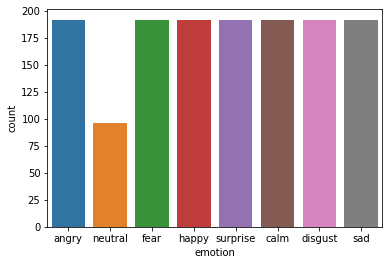

In [ ]:
sns.countplot(ravdess_data.emotion)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


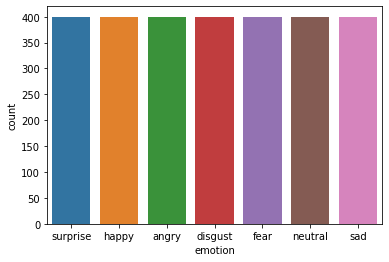

In [ ]:
sns.countplot(tess_data.emotion)

We can merge the 2 datasets and then explore it.

In [ ]:
data = pd.concat([ravdess_data,tess_data],axis=0)

In [ ]:
len(data)

4240

Shuffling the dataframe

In [ ]:
data = data.sample(frac=1,random_state=18).reset_index(drop=True)

In [ ]:
data.head(10)

,emotion,path
0,neutral,TESS/OAF_death_neutral.wav
1,fear,TESS/OAF_wire_fear.wav
2,disgust,TESS/YAF_ditch_disgust.wav
3,disgust,TESS/OAF_sour_disgust.wav
4,surprise,RAVDESS/Actor_09/03-01-08-02-01-01-09.wav
5,surprise,TESS/YAF_judge_ps.wav
6,surprise,TESS/YAF_wag_ps.wav
7,sad,TESS/YAF_whip_sad.wav
8,surprise,RAVDESS/Actor_20/03-01-08-02-02-01-20.wav
9,fear,RAVDESS/Actor_15/03-01-06-02-01-01-15.wav


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


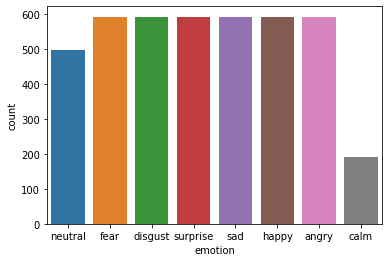

In [ ]:
sns.countplot(data.emotion)

###Before exploring the audio files we need to know something about audio as a digital file format.

**Sampling rate** or sampling frequency defines the number of samples per second (or per other unit) taken from a continuous signal to make a discrete or digital signal.
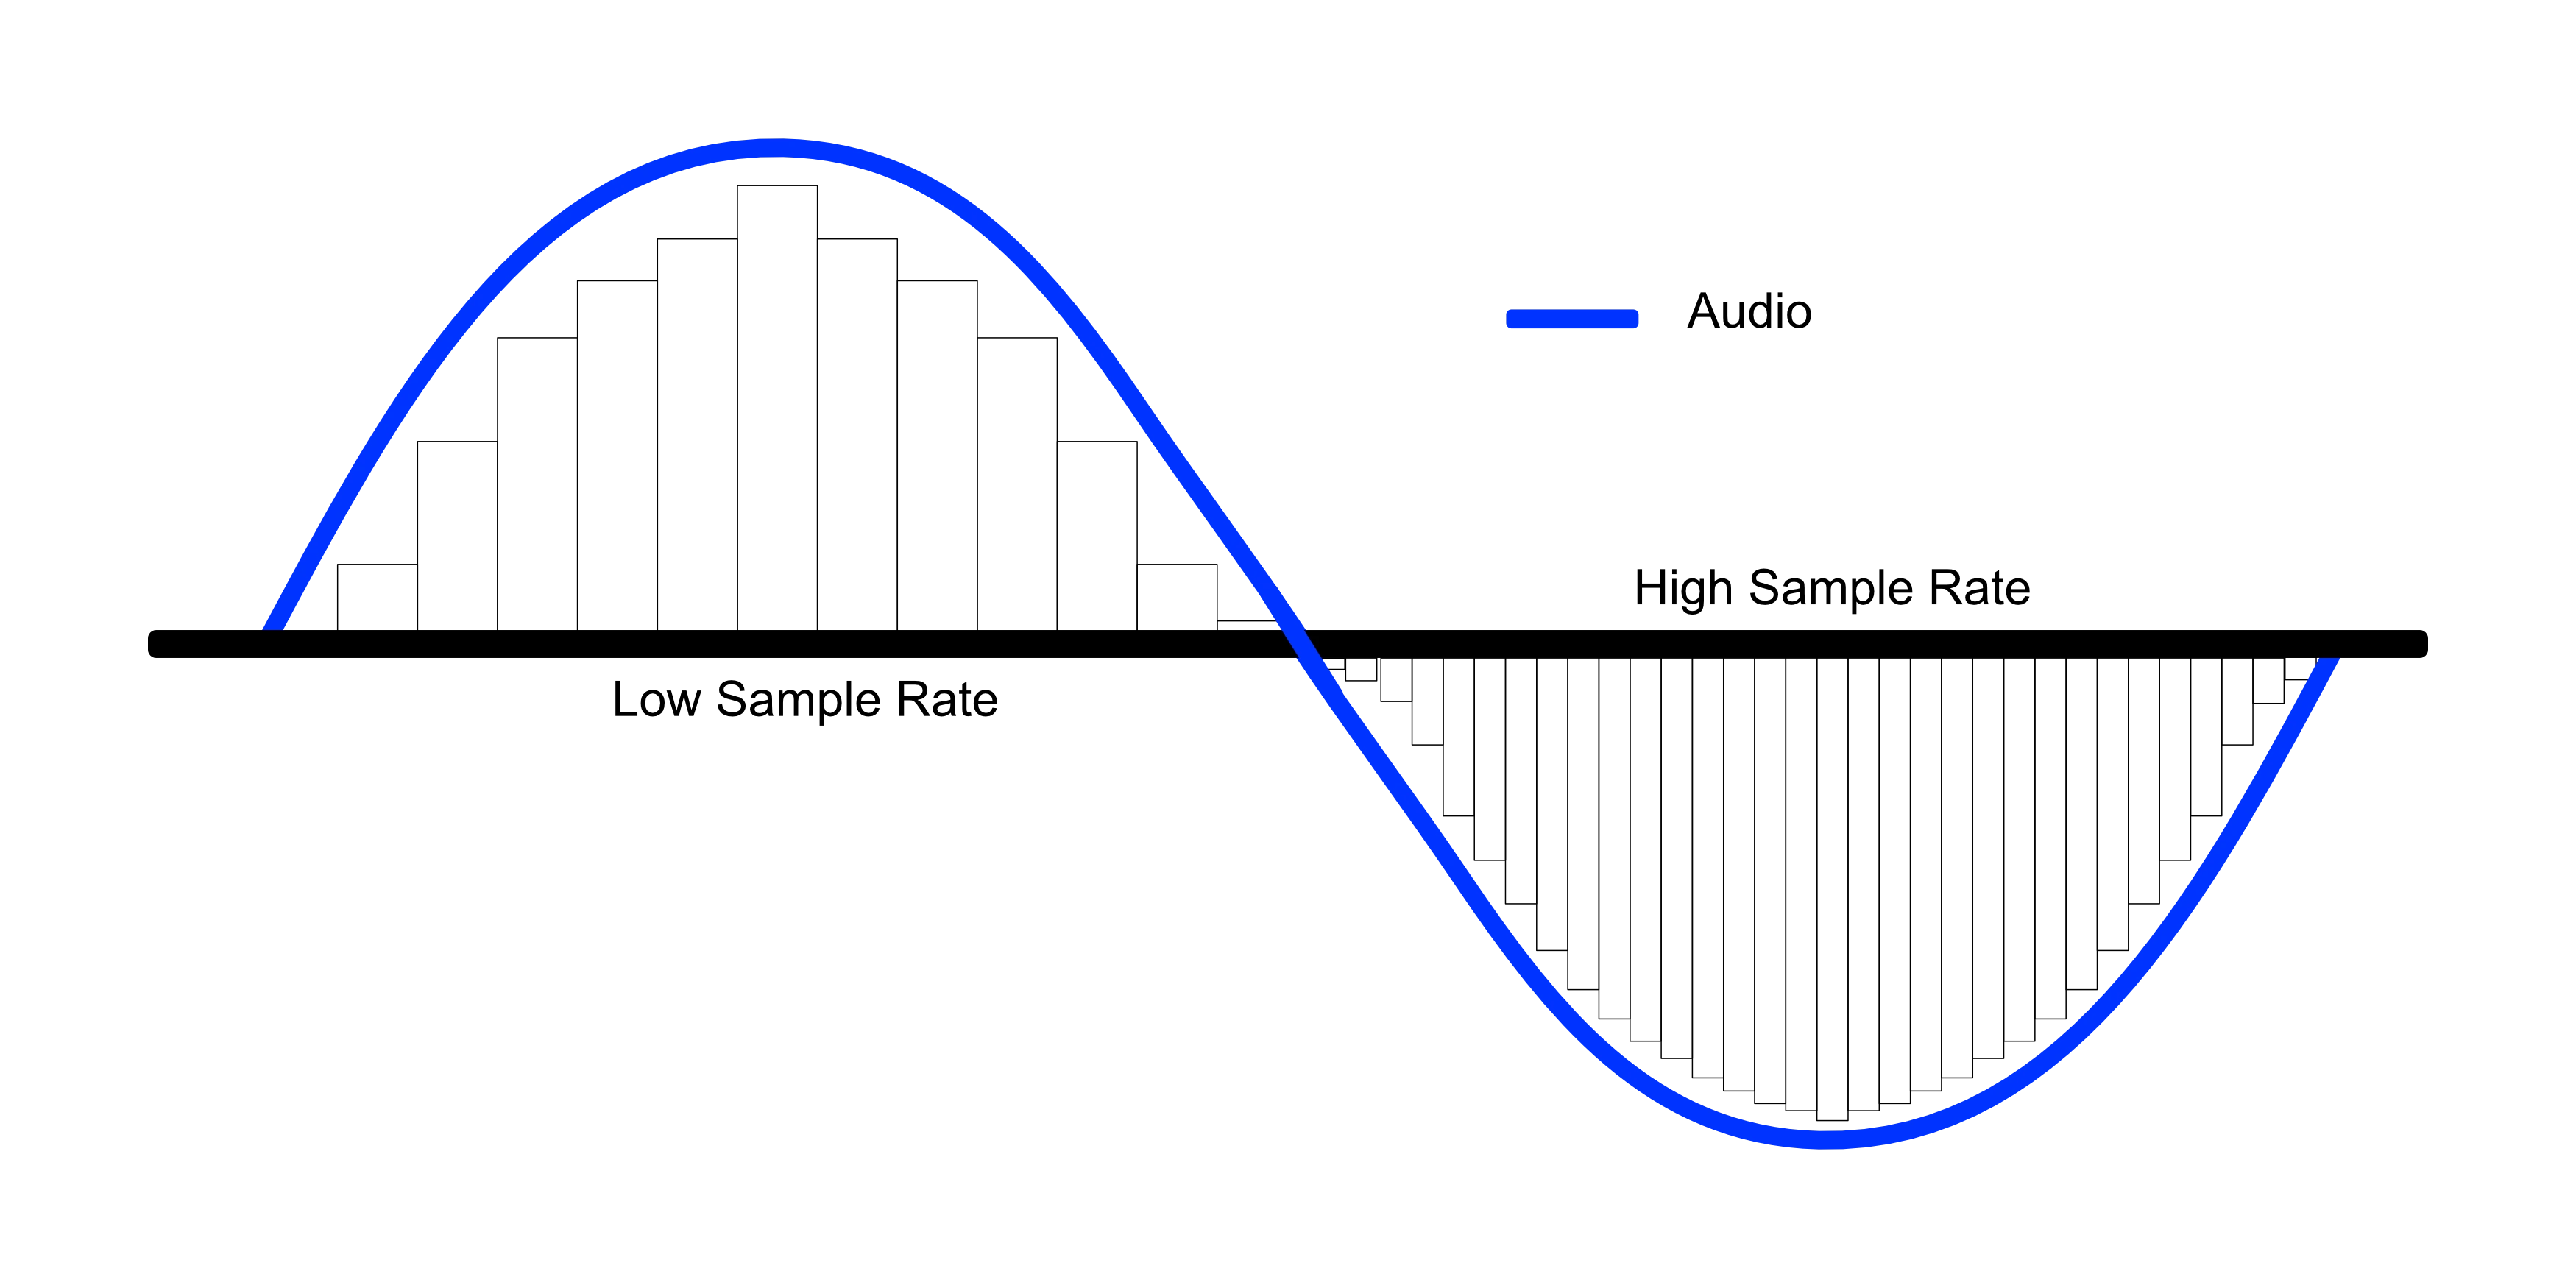


**Bit depth**, in a nutshell, relates to the dynamic range in audio. In slightly more detail, the bit depth is the number of ‘bits’ of information in every single sample. The more bits, the more dynamic range.

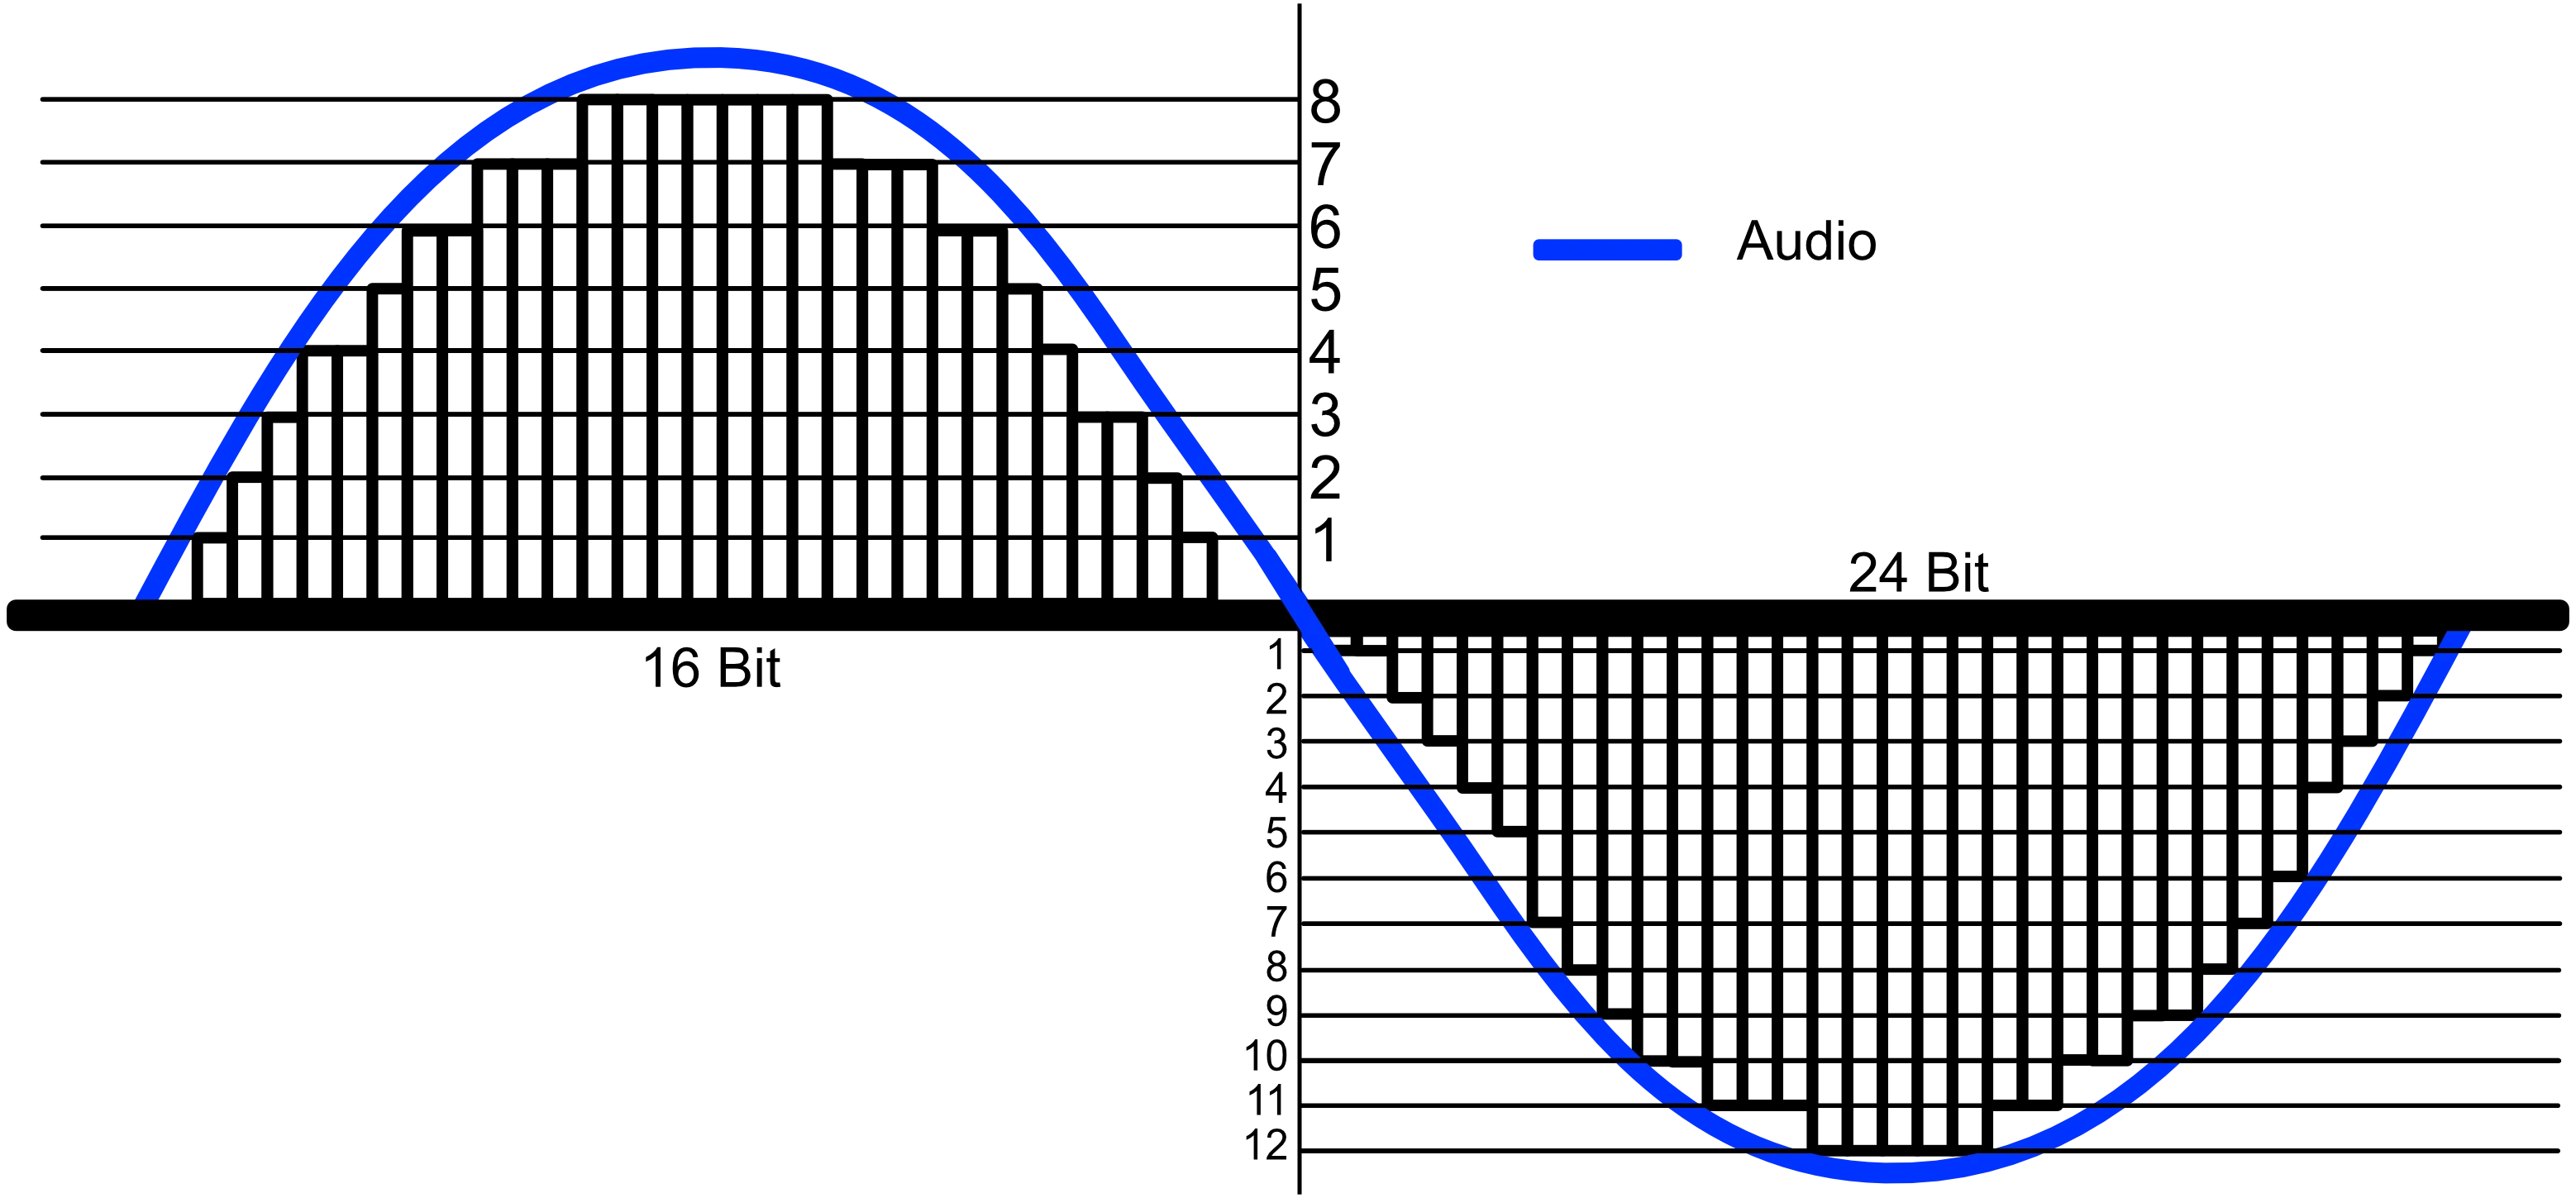

[Image and Definations from this website](https://www.masteringthemix.com/blogs/learn/113159685-sample-rates-and-bit-depth-in-a-nutshell)

- TESS audio files were recorded at 16-bits per sample, at a sampling rate of 24,414 Hz
- RAVDESS audio files were recorded at 16 bits per sample, at a sampling rate of 48 kHz i.e. 48,000 Hz

**Basic Idea**

We need to understand that audio as a 1D array like images are 2D arrays rows and columns in sound we have amplitude over time but all we need is the amplitude data arranged linearly in 1 dimension which is sufficient to understand the audio when its sampling rate is already given.
[Check this discussion for more insights](https://hydrogenaud.io/index.php?topic=116269.0)

Lets make and listen to a sine wave.

Here we use the Audio() from IPython to play the audio


In [ ]:
duration = 1
sampling_rate = 48000
audio_wave_data = np.sin(np.linspace(0, 11000,duration*sampling_rate))
Audio(audio_wave_data, rate=sampling_rate)

We can visualize the audio data by 2 ways
- **Waveplot** is the plotting of the waveform of amplitude vs time.
- **Spectrograms** is a visual representation of the spectrum of frequencies of a signal as it varies with time. A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.

we can do that using a library called **Librosa**

Text(0.5, 1.0, 'The Sine Waveplot')

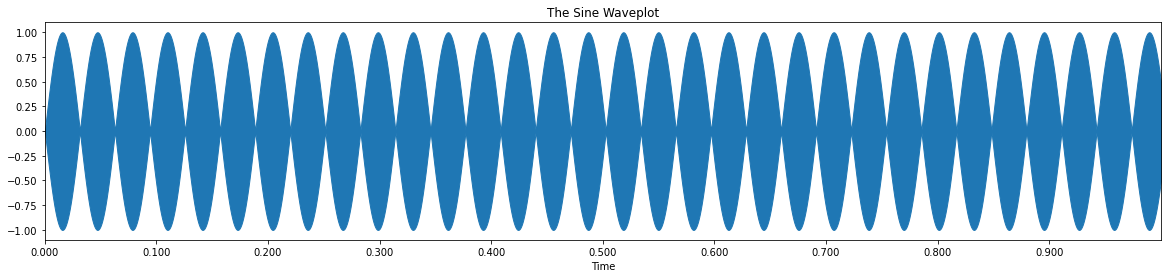

In [ ]:
audio_wave_data_low_freq = np.sin(np.linspace(0, 100,duration*sampling_rate))
plt.figure(figsize=(20, 4))
lrdis.waveplot(audio_wave_data_low_freq,sampling_rate)
plt.title("The Sine Waveplot")

In time-domain the amplitude is the voltage of the wave or the height from zero to peak. In the frequency domain (FT domain) the amplitude of is the strength of the frequency. In signal processing the amplitude is expressed in db. So you can see which frequency is louder and which is quieter.

In the below picture the Spectrogram is the view from top where time is in x-axis , frequency is in y axis and amplitude given by colours.

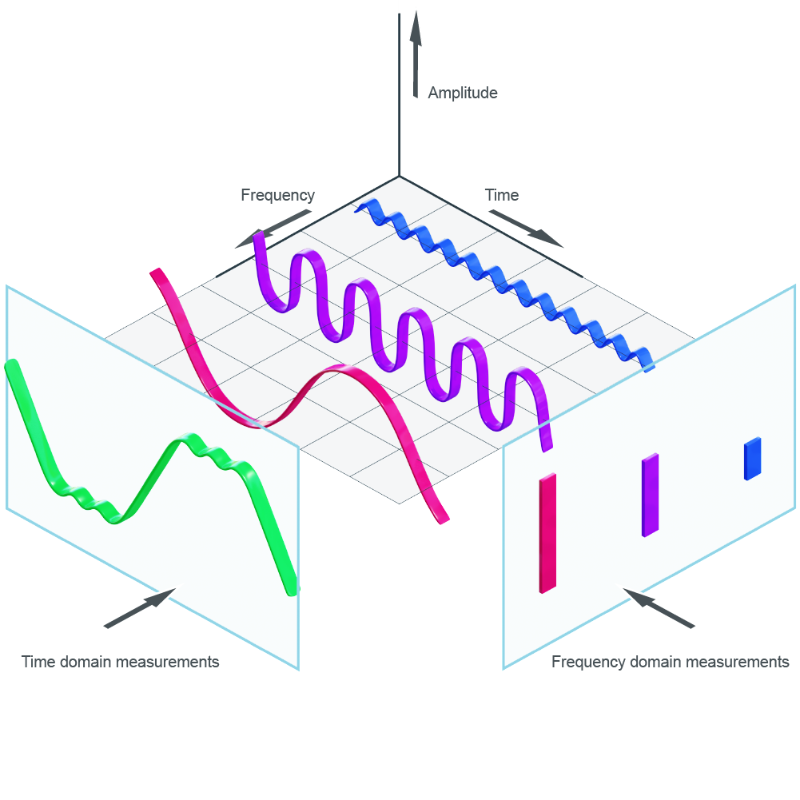

Now that we understand what a spectrogram is but we need to understand a specific one called **Mel Spectrogram**.

Here is a good discussion on 
- [**Why almost all neural speech processing involves Mel Spectrograms?**](https://stats.stackexchange.com/questions/523909/why-almost-all-neural-speech-processing-involves-mel-spectrograms)
- [**Getting to Know the Mel Spectrogram**](https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0tps://)

Basically the Mel Spectrogram involves a spectrogram having the frequency axis on **Mel Scale**. Heres why:

This Mel Scale is constructed such that sounds of equal distance from each other on the Mel Scale, also “sound” to humans as they are equal in distance from one another.
In contrast to Hz scale, where the difference between 500 and 1000 Hz is obvious, whereas the difference between 7500 and 8000 Hz is barely noticeable.

So it mimics human hearing better so its a preferred audio feature for training models.

But below is a short easy way to generate Mel Spectrogram

Text(0.5, 1.0, 'The Sine wave Mel Spectrogram')

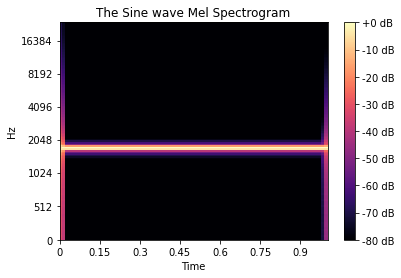

In [ ]:
mel_spec = lr.feature.melspectrogram(audio_wave_data,sr=sampling_rate)
mel_spec_db = lr.power_to_db(mel_spec, ref=np.max)
lrdis.specshow(mel_spec_db, sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title("The Sine wave Mel Spectrogram")

According to many on the Internet MFCC(Mel-Frequency Cepstral Coefficients) is better than a simple spectrogram for model training. 

Any sound generated by humans is determined by the shape of their vocal tract (including tongue, teeth, etc). If this shape can be determined correctly, any sound produced can be accurately represented. The envelope of the time power spectrum of the speech signal is representative of the vocal tract and MFCC (which is nothing but the coefficients that make up the Mel-frequency cepstrum) accurately represents this envelope.(Source:[The dummy’s guide to MFCC](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd#:~:text=Any%20sound%20generated,arrived%20at%20MFCCs%3A))

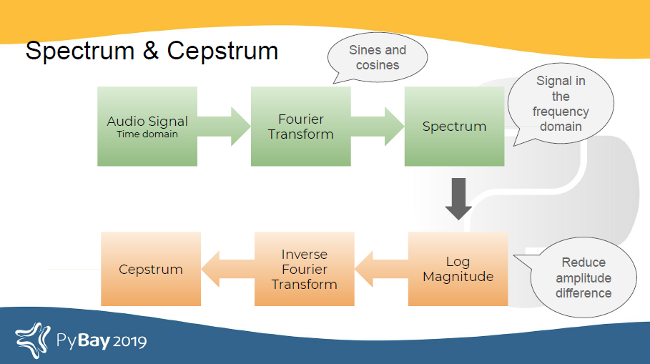

Below is a easy way to find MFCC using librosa

Text(0.5, 1.0, 'MFCC plot for Sine wave')

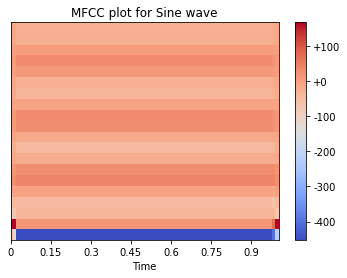

In [ ]:
mfcc = lr.feature.mfcc(audio_wave_data,sr=sampling_rate)
lrdis.specshow(mfcc, sr=sampling_rate, x_axis='time');
plt.colorbar(format="%+2.0f")
plt.title("MFCC plot for Sine wave")

##Check samples of data

###A sample from TESS

In [ ]:
sam = tess_data.sample(1).values

In [ ]:
audio_wave_data,sampling_rate = lr.load(sam[0][1])

In [ ]:
Audio(audio_wave_data, rate=sampling_rate)

Text(0.5, 1.0, 'disgust')

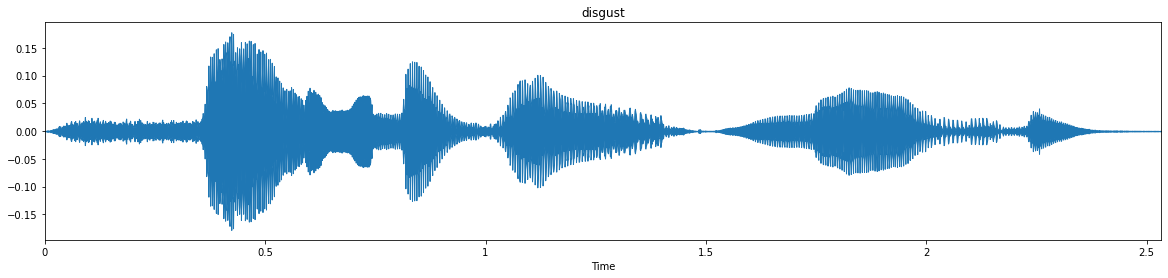

In [ ]:
plt.figure(figsize=(20, 4))
lrdis.waveplot(audio_wave_data,sampling_rate)
plt.title(sam[0][0])

Text(0.5, 1.0, 'disgust')

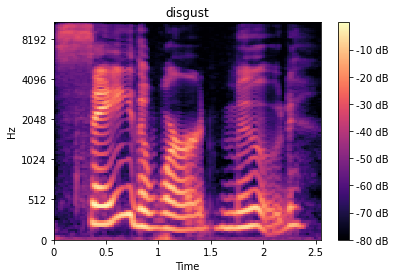

In [ ]:
mel_spec = lr.feature.melspectrogram(audio_wave_data,sr=sampling_rate)
mel_spec_db = lr.power_to_db(mel_spec, ref=np.max)
lrdis.specshow(mel_spec_db, sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title(sam[0][0])

Text(0.5, 1.0, 'disgust')

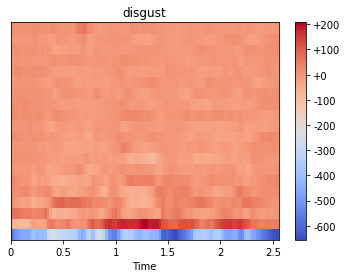

In [ ]:
mfcc = lr.feature.mfcc(audio_wave_data,sr=sampling_rate)
lrdis.specshow(mfcc, sr=sampling_rate, x_axis='time');
plt.colorbar(format="%+2.0f")
plt.title(sam[0][0])

###Asample from RAVDESS

In [ ]:
sam = ravdess_data.sample(1).values

In [ ]:
audio_wave_data,sampling_rate = lr.load(sam[0][1])

In [ ]:
Audio(audio_wave_data, rate=sampling_rate)

Text(0.5, 1.0, 'sad')

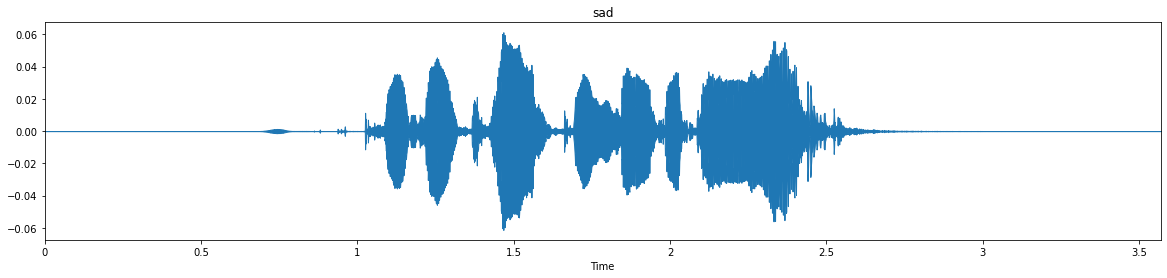

In [ ]:
plt.figure(figsize=(20, 4))
lrdis.waveplot(audio_wave_data,sampling_rate)
plt.title(sam[0][0])

Text(0.5, 1.0, 'sad')

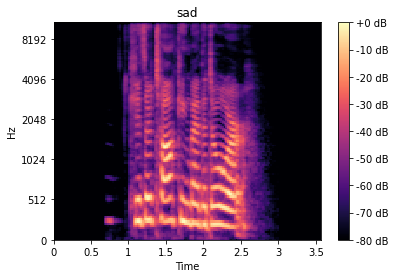

In [ ]:
mel_spec = lr.feature.melspectrogram(audio_wave_data,sr=sampling_rate)
mel_spec_db = lr.power_to_db(mel_spec, ref=np.max)
lrdis.specshow(mel_spec_db, sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.title(sam[0][0])

Text(0.5, 1.0, 'sad')

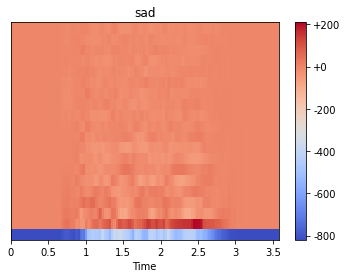

In [ ]:
mfcc = lr.feature.mfcc(audio_wave_data,sr=sampling_rate)
lrdis.specshow(mfcc, sr=sampling_rate, x_axis='time');
plt.colorbar(format="%+2.0f")
plt.title(sam[0][0])

# Feature extraction

Here I have focused one of the may possible features of audio data. 

Mel Spectrogram and the better version of it the MFCC and as we know MFCC is known to be a good feature for sound recognition purposes we will also use that feature in our model.

The functions generate 128 mel-frequency spectrogram coefficients and 20 MFCC coefficients and then we take the mean of the coefficients over time axis.

In [ ]:
x = np.arange(0,148)      #final extracted feature will be stored here so total=128+20
for i, row in enumerate(data.index):
  row_data = np.array([])     #store each rowdata
  file_path = data.loc[row,'path']      #get file path
  audio_wave_data,sampling_rate = lr.load(file_path)      #load file
  mfcc = lr.feature.mfcc(audio_wave_data,sr=sampling_rate).T      #generate mfcc data and transpose
  mel_spec = lr.feature.melspectrogram(audio_wave_data,sr=sampling_rate)     #generate mfcc data
  mel_spec_db = lr.power_to_db(mel_spec, ref=np.max).T        #to dB and transpose
  mfcc_mean = np.mean(mfcc,axis = 0)          #calculate mean of mfcc along time axis
  row_data = np.hstack((row_data,mfcc_mean))
  mel_spec_mean = np.mean(mel_spec_db,axis = 0)      #calculate mean of mel_spec along time axis
  row_data = np.hstack((row_data,mel_spec_mean))    
  x = np.vstack((x,row_data))

In [ ]:
x_data = pd.DataFrame(x)
x_data.drop(0,axis=0,inplace=True)
x_data.reset_index(drop=True,inplace=True)
x_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147
0,-504.219452,64.267960,17.805479,7.135756,11.352305,6.064674,-6.652463,-5.562901,-8.378510,2.324500,-10.081330,2.204591,-4.289444,7.194279,6.016685,4.522824,-0.749471,5.842855,-3.574143,-0.149218,-28.931139,-41.121437,-57.455349,-59.076149,-54.362404,-33.481804,-25.343601,-31.954990,-53.723057,-59.058128,-58.825539,-50.986748,-34.175522,-25.819672,-28.740879,-44.345047,-51.655029,-51.639030,-52.458420,-41.331661,...,-56.807617,-56.871582,-55.866043,-58.124886,-60.393784,-62.941624,-63.076134,-62.628136,-62.500732,-62.759705,-61.047752,-62.060493,-61.810841,-60.054996,-61.903080,-62.930767,-63.694759,-64.633926,-62.550842,-60.364231,-59.401688,-60.394291,-61.369614,-60.519428,-57.816853,-58.806103,-58.976982,-57.705338,-58.868896,-60.235092,-59.523067,-60.257927,-60.876514,-59.900890,-58.721539,-58.763260,-59.586601,-61.890556,-66.413849,-76.182304
1,-429.182526,69.954216,14.840646,-12.210953,-6.556542,1.646092,-12.946275,-2.896422,-17.670971,5.829455,-21.782431,-4.461928,-6.535601,-1.631949,-4.752864,2.238166,-5.784366,3.205195,-1.848076,-5.661468,-33.756187,-48.298843,-59.231384,-60.994812,-59.822834,-57.021965,-57.578133,-58.344032,-49.793468,-26.225363,-17.712616,-23.146088,-38.776699,-48.675583,-49.492462,-49.839733,-50.987335,-51.569191,-50.961983,-45.220295,...,-58.058033,-59.333805,-59.487740,-62.824036,-63.766827,-64.593956,-65.421860,-66.195099,-65.665886,-62.171551,-62.104214,-63.471252,-65.009232,-64.870079,-62.494911,-59.286396,-59.590912,-60.872150,-62.017174,-62.673656,-60.601234,-57.936588,-55.785168,-57.200649,-56.279713,-55.171135,-55.054848,-56.871014,-57.732094,-57.635578,-58.141701,-59.459652,-59.666946,-60.939659,-62.797863,-62.409893,-63.484608,-65.832687,-69.872467,-77.322006
2,-431.373108,49.589470,-2.651820,31.474798,-10.021777,0.837466,-12.451966,-10.266146,-6.513049,1.689942,-11.277207,8.322824,-3.444709,0.727599,1.538594,-5.274369,1.759350,-0.103754,-7.782680,3.789396,-45.326588,-46.453552,-52.180485,-53.716503,-50.394867,-47.373699,-42.334911,-40.229931,-42.737114,-44.413166,-44.487820,-45.425167,-46.157192,-45.581604,-43.585945,-42.320419,-41.455536,-42.002522,-42.452888,-44.060703,...,-52.333649,-50.993103,-49.507439,-48.561443,-47.955326,-48.185467,-48.993370,-51.029045,-52.881859,-53.201084,-54.008499,-56.902531,-59.109528,-58.834236,-59.842022,-60.043674,-59.750084,-59.221104,-58.221378,-57.196938,-56.864529,-56.900490,-57.818951,-57.419987,-56.887421,-57.225391,-59.360874,-61.479713,-62.537651,-62.553303,-62.707405,-62.623768,-61.720695,-61.986095,-63.200813,-63.881245,-65.506279,-67.098282,-69.405853,-74.915810
3,-409.874054,66.453110,15.874819,-13.968890,-3.785996,1.218946,-7.927495,0.314116,-15.340699,5.779891,-11.738800,3.750555,-4.127532,5.476612,0.450017,4.697948,-6.234733,5.449975,-4.504411,-5.016900,-33.827221,-48.712318,-58.920246,-59.323704,-50.226448,-41.120651,-38.671501,-42.159340,-46.544044,-46.592571,-45.243637,-43.046253,-43.427025,-45.275288,-45.275585,-44.512886,-40.912865,-39.006744,-40.005630,-40.077587,...,-57.646900,-57.881924,-59.289459,-61.340248,-61.913460,-62.119713,-62.262917,-62.006111,-62.947247,-63.347534,-62.107468,-62.851242,-60.872395,-60.056904,-60.183640,-60.095249,-60.208035,-59.213673,-58.125168,-57.900356,-58.221779,-58.376820,-58.791595,-57.424114,-55.219856,-53.701157,-53.046360,-53.239468,-54.488384,-55.703659,-56.574928,-56.914852,-57.125690,-56.490822,-56.617397,-57.983204,-59.687534,-62.745323,-68.302582,-75.070023
4,-635.147644,52.915707,3.443139,14.124011,7.903279,-3.983960,-3.017945,-2.698547,-1.958589,-3.081782,-4.902399,-1.285937,-3.077272,-2.425417,-2.094073,-1.565413,-0.079111,-2.343355,-2.862191,1.738060,-66.693512,-66.984756,-60.818668,-58.397152,-57.760818,-56.203308,-

#Scaling, encoding and spliting the data

In [ ]:
sc = StandardScaler()
x_data = sc.fit_transform(x_data)

In [ ]:
data['emotion'] = data['emotion'].map({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5, 'fear':6, 'disgust':7, 'surprise':8})
data.head()

,emotion,path
0,1,TESS/OAF_death_neutral.wav
1,6,TESS/OAF_wire_fear.wav
2,7,TESS/YAF_ditch_disgust.wav
3,7,TESS/OAF_sour_disgust.wav
4,8,RAVDESS/Actor_09/03-01-08-02-01-01-09.wav


In [ ]:
np.sort(data.emotion.unique())

array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
y = data.emotion

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(x_data, y, test_size=0.1)

#Model building

In [ ]:
svc = SVC()
svc.fit(xtrain,ytrain)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svc.predict(xtest)
y_pred_train = svc.predict(xtrain)

# Model Evaluation
## Training Accuracy

In [ ]:
accuracy_score(ytrain,y_pred_train)

0.8440775681341719

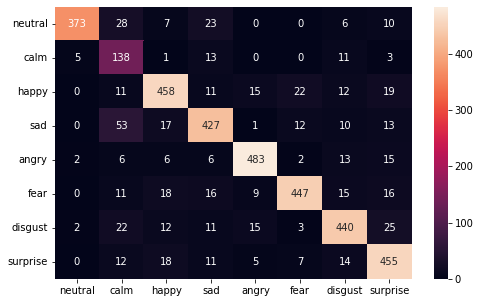

In [ ]:
plt.figure(figsize=(8,5))
ticks = ['neutral','calm','happy','sad','angry','fear','disgust','surprise']
sns.heatmap(confusion_matrix(ytrain,y_pred_train),xticklabels=ticks,yticklabels=ticks,annot=True,fmt = 'g')

In [ ]:
print(classification_report(ytrain,y_pred_train))

              precision    recall  f1-score   support

           1       0.98      0.83      0.90       447
           2       0.49      0.81      0.61       171
           3       0.85      0.84      0.84       548
           4       0.82      0.80      0.81       533
           5       0.91      0.91      0.91       533
           6       0.91      0.84      0.87       532
           7       0.84      0.83      0.84       530
           8       0.82      0.87      0.84       522

    accuracy                           0.84      3816
   macro avg       0.83      0.84      0.83      3816
weighted avg       0.86      0.84      0.85      3816



##Validation accuracy

In [ ]:
accuracy_score(ytest,y_pred)

0.8325471698113207

In [ ]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           1       1.00      0.80      0.89        49
           2       0.52      0.76      0.62        21
           3       0.71      0.77      0.74        44
           4       0.79      0.81      0.80        59
           5       0.93      0.93      0.93        59
           6       0.89      0.85      0.87        60
           7       0.85      0.81      0.83        62
           8       0.86      0.86      0.86        70

    accuracy                           0.83       424
   macro avg       0.82      0.82      0.82       424
weighted avg       0.85      0.83      0.84       424



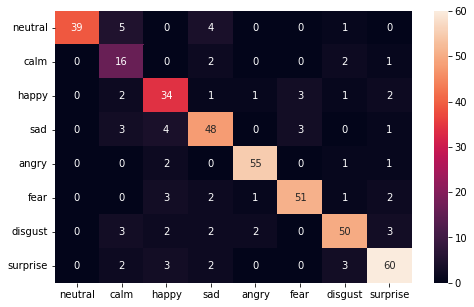

In [ ]:
plt.figure(figsize=(8,5))
sns.heatmap(confusion_matrix(ytest,y_pred),xticklabels=ticks,yticklabels=ticks,annot=True,fmt = 'g')

#KFold Cross-Validation

In [ ]:
cv_scores_validation = []
cv_scores_training = []

kf = KFold(n_splits=10)

for train_index, test_index in kf.split(x_data):

    xtrain, xtest = x_data[train_index], x_data[test_index]
    ytrain, ytest = y[train_index], y[test_index]

    svc.fit(xtrain,ytrain)
    y_pred = svc.predict(xtest)
    y_pred_train = svc.predict(xtrain)
    cv_scores_validation.append(accuracy_score(ytest, y_pred))
    cv_scores_training.append(accuracy_score(ytrain, y_pred_train))

In [ ]:
print(cv_scores_training)
print(np.mean(cv_scores_training))

[0.8435534591194969, 0.8422431865828093, 0.845125786163522, 0.8440775681341719, 0.8453878406708596, 0.8490566037735849, 0.8456498951781971, 0.8474842767295597, 0.8435534591194969, 0.8456498951781971]
0.8451781970649895


In [ ]:
print(cv_scores_validation)
print(np.mean(cv_scores_validation))

[0.8231132075471698, 0.8207547169811321, 0.785377358490566, 0.8136792452830188, 0.8325471698113207, 0.7924528301886793, 0.8278301886792453, 0.7924528301886793, 0.8372641509433962, 0.8301886792452831]
0.8155660377358492


So we can declare that the model is having good accuracy without much overfitting.

#Save model

We will need the svc model and the standard scaler model during deployment so we need to save it. Here we will use pickle to save them.

In [ ]:
svc_model = pickle.dump(svc,open('svc_model.pickle','wb'))
scaler_model = pickle.dump(svc,open('scaler_model.pickle','wb'))